In [1]:
import pandas as pd
import numpy as np
import os
import requests
from dataFunction import *
import sys
import matplotlib.pyplot as plt
import tkinter
import matplotlib
from sklearn.linear_model import LinearRegression
%matplotlib inline
import seaborn as sns
# import missingno as msno
# plt.rcParams["figure.figsize"] = (5,8) # (w, h)

/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_FL_Ectrie/thesis_fl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def download_file(url, save_folder):
    '''If the file isn't already in the save folder, download it.'''
    local_filename = url.split('/')[-1]  #Get the name of the file being downloaded

    # if the file exists, don't download it again
    if os.path.isfile(os.path.join(save_folder, local_filename)): return os.path.join(save_folder, local_filename)

    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(os.path.join(save_folder, local_filename), 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)
    return os.path.join(save_folder, local_filename)  #Returns the path pointing to the local file


In [3]:
cleveland = download_file(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", os.getcwd())
switzerland = download_file(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
        os.getcwd())
va = download_file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                       os.getcwd())
hungarian = download_file(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data", os.getcwd())


In [4]:
# Step 2: load the data into pandas DataFrames and then merge the four files into a single dataframe
cleveland_df = pd.read_csv(cleveland, header=None, na_values =["?", -9.0])
switzerland_df = pd.read_csv(switzerland, header=None, na_values =["?", -9.0])
va_df = pd.read_csv(va, header=None, na_values =["?", -9.0])
hungarian_df = pd.read_csv(hungarian, sep=" ", header=None, na_values =["?", -9.0])

# add headers to the data frames
headers = {0 : "Age",
           1 : "Sex", # 1 = male; 0 = female
           2 : "ChestPainType",  # chest pain type, 
                      # Value 1: typical angina, 
                      # Value 2: atypical angina, 
                      # Value 3: non-anginal pain
                      # Value 4: asymptomatic
           3 : "RestingBP", # resting blood pressure 
                           #(in mm Hg on admission to the hospital)
           4 : "Cholesterol", # serum cholestoral in mg/dl, 
            # Wanneer je totale cholesterolgehalte boven de 240 mg/dl is, 
            # wordt het zelfs gevaarlijk en met je je cholesterol verlagen. 
           5 : "FastingBS", # fasting blood sugar > 120 mg/dl 
                     # (1 = true; 0 = false)
           6 : "RestingECG",#  resting electrocardiographic results
                         # Value 0: normal
                         # Value 1: having ST-T wave abnormality 
                         # (T wave inversions and/or ST elevation or depression of > 0.05 mV)
                         # Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
           7 : "MaxHR", #maximum heart rate achieved
           8 : "ExerciseAngina",# exercise induced angina (1 = yes; 0 = no)
           9 : "Oldpeak", # ST depression induced by exercise relative to rest
           10 : "ST_Slope", # the slope of the peak exercise ST segment
                         # Value 1: upsloping
                         # Value 2: flat
                         # Value 3: downsloping
           11 : "ca", # number of major vessels (0-3) colored by flourosopy    
           12 : "thal", # Value 3: normal
                        # Value 6: fixed defect
                        # Value 7: reversable defect
           13 : "HeartDisease" # diagnosis of heart disease (angiographic disease status)
                            # Value 0 = < 50% diameter narrowing,
                            # Value 1 = > 50% diameter narrowing 
                            # It takes 5 levels based on angiographic disease status.
                            # 0-Healthy, 1-diagnosed with stage 1, 2-diagnosed with stage 2, 
                            # 3-diagnosed with stage 3, 4-diagnosed with stage 4.
          }
cleveland_df = cleveland_df.rename(columns=headers)
switzerland_df = switzerland_df.rename(columns=headers)
va_df = va_df.rename(columns=headers)
hungarian_df = hungarian_df.rename(columns=headers)
cleveland_df['Location'] = 'Cleveland'
switzerland_df['Location'] = 'Switzerland'
va_df['Location']='VA'
hungarian_df['Location']='Hungarian'
hungarian_df = hungarian_df[:-1]


# # make a binary target variable
# cleveland_df['target'] = cleveland_df['HeartDisease'].copy()
# cleveland_df.target = cleveland_df.target.replace([1, 2, 3, 4], 1)
# switzerland_df['target'] = switzerland_df['HeartDisease'].copy()
# switzerland_df.target = switzerland_df.target.replace([1, 2, 3, 4], 1)
# va_df['target'] = va_df['HeartDisease'].copy()
# va_df.target = va_df.target.replace([1, 2, 3, 4], 1)
# hungarian_df['target'] = hungarian_df['HeartDisease'].copy()
# hungarian_df.target = hungarian_df.target.replace([1, 2, 3, 4], 1)


In [73]:
# list_df = [cleveland_df, hungarian_df, switzerland_df, va_df]
# cont = ["Age", "RestingBP", "Cholesterol", "MaxHR"]
# for i in list_df:
#     for j in cont:
# # #     print('min', min(i.RestingBP))
#         print(np.mean(i[j]))
#         print(np.std(i[j]))
#         print(min(i[j]))
#         print(max(i[j]))
# # print('min', min(df.Oldpeak))
# # print('max', max(df.MaxHR))
# df.ca.isnull().sum()
missing_values = [feature for feature in df.columns if df[feature].isnull().sum() > 1]

for feature in missing_values:
  print(f"{feature} {np.round(df[feature].isnull().mean(), 4)}% missing values")

In [27]:
df = pd.concat([cleveland_df, switzerland_df, va_df, hungarian_df])
df.HeartDisease = df.HeartDisease.replace([1, 2, 3, 4], 1)
# df = df.drop(columns=['thal', 'ca'])
# # print(len(df))
# df = df.drop_duplicates()
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
# msno.matrix(df)
# fig.set_tight_layout(False)
# savefig('matrix.png')
# print(len(df))

In [16]:
df2.HeartDisease.value_counts().index

Float64Index([0.0, 1.0], dtype='float64')

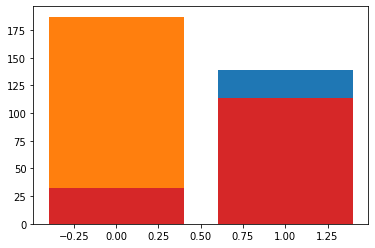

In [17]:
for i in np.unique(df.Location):
    df2 = df[df.Location == i]
    plt.bar(df2.HeartDisease.value_counts().index, df2.HeartDisease.value_counts(), label = i)
plt.show()

In [75]:
df = new_df(df)

In [76]:
y = df.Cholesterol
X = df.drop(columns=['Cholesterol', 'Location'])

In [77]:
X.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [78]:
X.describe()

Age         Sex  ChestPainType   RestingBP   FastingBS  \
count  742.000000  742.000000     742.000000  742.000000  742.000000   
mean    52.787062    0.754717       3.180593  132.615903    0.150943   
std      9.426064    0.430545       0.946476   17.720484    0.358235   
min     28.000000    0.000000       1.000000   92.000000    0.000000   
25%     46.000000    1.000000       2.000000  120.000000    0.000000   
50%     54.000000    1.000000       4.000000  130.000000    0.000000   
75%     59.000000    1.000000       4.000000  140.000000    0.000000   
max     77.000000    1.000000       4.000000  200.000000    1.000000   

       RestingECG       MaxHR  ExerciseAngina     Oldpeak    ST_Slope  \
count  742.000000  742.000000      742.000000  742.000000  742.000000   
mean     0.632075  140.175202        0.380054    0.915094    1.839623   
std      0.838156   24.967218        0.485727    1.091688    0.522006   
min      0.000000   69.000000        0.000000   -0.500000    1.000000   
25%      0.000000  122.000000        0.000000    0.000000    2.000000   
50%      0.000000  141.000000        0.000000    0.500000    2.000000   
75%      1.000000  160.000000        1.000000    1.500000    2.000000   
max      2.000000  202.000000        1.000000    6.200000    3.000000   

       HeartDisease  
count    742.000000  
mean       0.483827  
std        0.500075  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [79]:
switzerland_df = new_df(switzerland_df)
switzerland_df = df.drop(columns=['Cholesterol', 'Location'])

In [80]:
lr = LinearRegression().fit(X, y)
chol = lr.predict(switzerland_df)

In [81]:
chol.shape

(122,)

In [82]:
switzerland_df['Cholesterol'] = chol

In [83]:
switzerland_df

Age  Sex  ChestPainType  RestingBP  FastingBS  RestingECG  MaxHR  \
0     32    1              1       95.0        0.0         0.0  127.0   
1     34    1              4      115.0        0.0         0.0  154.0   
2     35    1              4      125.0        0.0         0.0  130.0   
3     36    1              4      110.0        0.0         0.0  125.0   
4     38    0              4      105.0        0.0         0.0  166.0   
..   ...  ...            ...        ...        ...         ...    ...   
118   70    1              4      115.0        0.0         1.0   92.0   
119   70    1              4      140.0        1.0         0.0  157.0   
120   72    1              3      160.0        0.0         2.0  114.0   
121   73    0              3      160.0        0.0         1.0  121.0   
122   74    1              2      145.0        0.0         1.0  123.0   

     ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  Cholesterol  
0               0.0      0.7       1.0             1   218.850308  
1               0.0      0.2       1.0             1   237.588349  
2               1.0      0.3       2.0             1   234.849664  
3               1.0      1.0       2.0             1   226.099825  
4               0.0      2.8       1.0             1   260.100212  
..              ...      ...       ...           ...          ...  
118             1.0      0.0       2.0             1   211.804120  
119             1.0      2.0       2.0             1   227.969063  
120             0.0      1.6       2.0             0   220.505627  
121             0.0      0.0       1.0             1   265.039108  
122             0.0      1.3       1.0             1   223.853931  

[122 rows x 12 columns]

In [21]:
df.columns.array
['Age', ]

['Age']

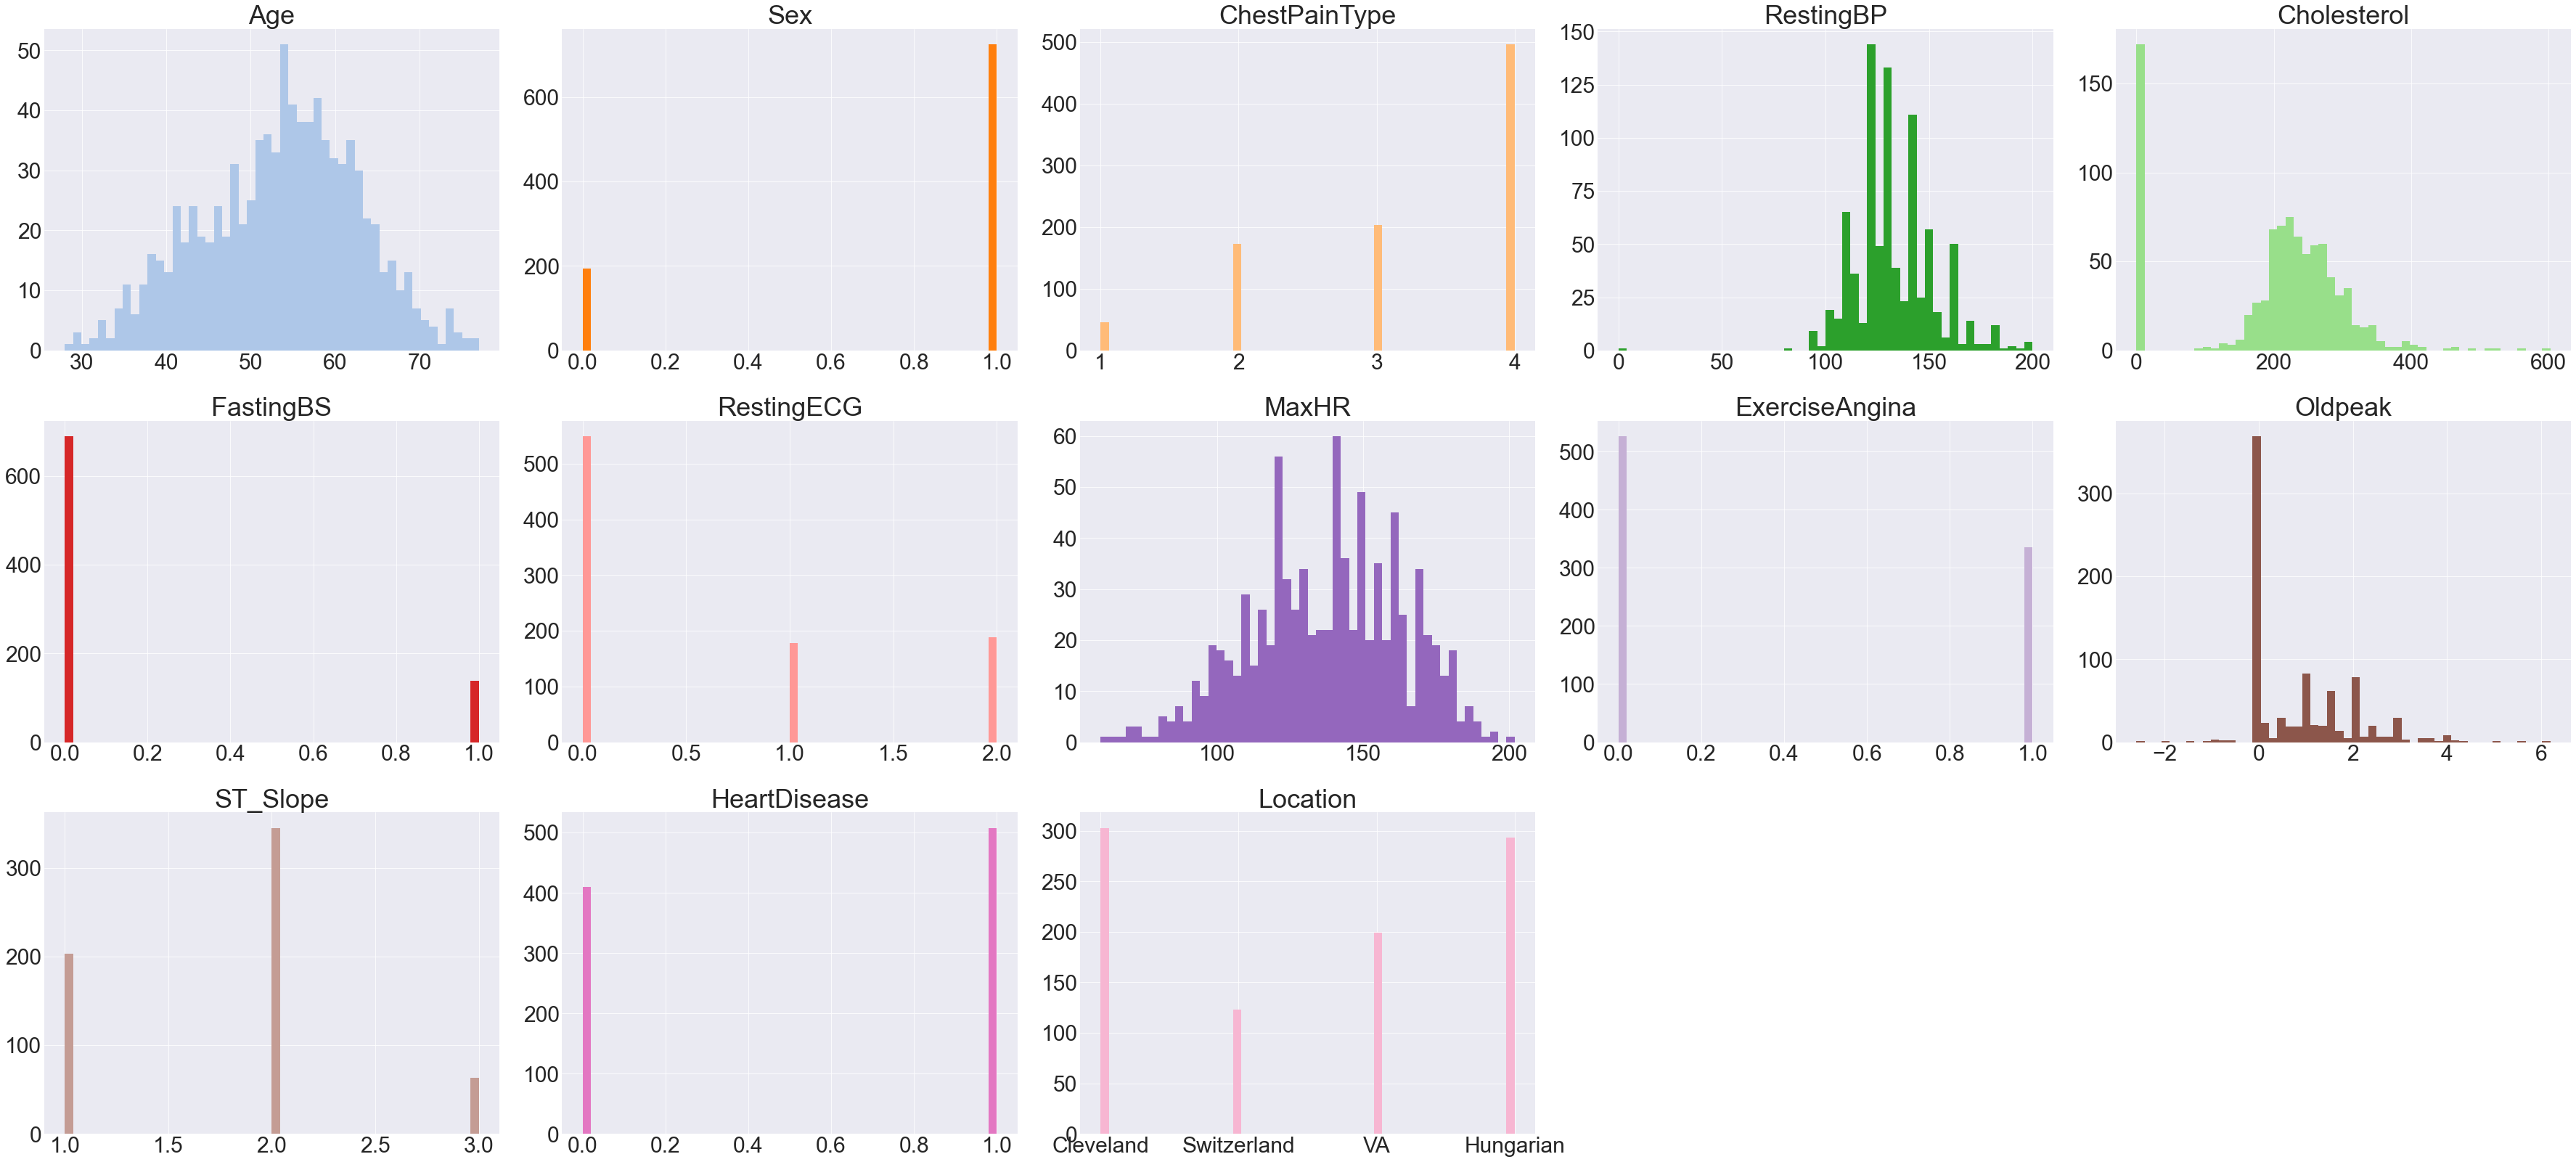

In [28]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab20')
plt.rcParams.update({'font.size': 30})
num=1
f= plt.figure(figsize=(50,30))
for var in list(df.columns.array):
    ax = f.add_subplot(4,5,num)
    a = np.asarray(df[var].dropna())
    ax.hist(a, bins=50, color=palette(num))
    ax.set_title(var)
    num+=1
f.savefig('distribution.png')

In [29]:
df.isnull().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP          59
Cholesterol        29
FastingBS          90
RestingECG          2
MaxHR              55
ExerciseAngina     55
Oldpeak            62
ST_Slope          307
HeartDisease        0
Location            0
dtype: int64

In [ ]:
df.describe()
df.dtypes

Age               float64
Sex               float64
ChestPainType     float64
RestingBP         float64
Cholesterol       float64
FastingBS         float64
RestingECG        float64
MaxHR             float64
ExerciseAngina    float64
Oldpeak           float64
ST_Slope          float64
HeartDisease      float64
Location           object
dtype: object

In [ ]:
perc = 35.0 
min_count =  int(((100-perc)/100)*df.shape[1] + 1)
df = df.dropna( axis=0, thresh=min_count)
print(len(df))

864


In [ ]:
# print(len(mod_df))
918 - 864 

54

In [ ]:
df.isnull().sum()
# df.Sex.value_counts()
# mod_df.isnull().groupby(mod_df['Location']).sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP          59
Cholesterol        29
FastingBS          90
RestingECG          2
MaxHR              55
ExerciseAngina     55
Oldpeak            62
ST_Slope          307
HeartDisease        0
Location            0
dtype: int64

In [ ]:
# # FILL MISSING VALUES WITH MEDIAN
df.ST_Slope = df.ST_Slope.fillna(df.ST_Slope.median())
df.RestingBP = df.RestingBP.fillna(df.RestingBP.median())
df.FastingBS = df.FastingBS.fillna(df.FastingBS.median())
df.RestingECG = df.RestingECG.fillna(df.RestingECG.median())
df.Cholesterol = df.Cholesterol.fillna(df.Cholesterol.median())
df.MaxHR = df.MaxHR.fillna(df.MaxHR.median())
df.ExerciseAngina = df.ExerciseAngina.fillna(df.ExerciseAngina.median())
df.Oldpeak = df.Oldpeak.fillna(df.Oldpeak.median())

# # DROP ROW WHERE RESTING BP = 0
df = df[df.RestingBP != 0]

In [ ]:
len(df)

863

In [ ]:
df[df.Cholesterol == 0]

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0    32.0  1.0            1.0       95.0          0.0        0.0         0.0   
1    34.0  1.0            4.0      115.0          0.0        0.0         0.0   
2    35.0  1.0            4.0      130.0          0.0        0.0         0.0   
3    36.0  1.0            4.0      110.0          0.0        0.0         0.0   
4    38.0  0.0            4.0      105.0          0.0        0.0         0.0   
..    ...  ...            ...        ...          ...        ...         ...   
76   49.0  1.0            1.0      130.0          0.0        0.0         1.0   
92   67.0  1.0            4.0      120.0          0.0        1.0         0.0   
98   43.0  1.0            4.0      122.0          0.0        0.0         0.0   
99   63.0  1.0            3.0      130.0          0.0        1.0         1.0   
102  48.0  1.0            3.0      102.0          0.0        0.0         1.0   

     MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease     Location  
0    127.0             0.0      0.7       1.0           1.0  Switzerland  
1    154.0             0.0      0.2       1.0           1.0  Switzerland  
2    130.0             1.0      0.5       2.0           1.0  Switzerland  
3    125.0             1.0      1.0       2.0           1.0  Switzerland  
4    166.0             0.0      2.8       1.0           1.0  Switzerland  
..     ...             ...      ...       ...           ...          ...  
76   145.0             0.0      3.0       2.0           1.0           VA  
92   150.0             0.0      1.5       3.0           1.0           VA  
98   120.0             0.0      0.5       1.0           1.0           VA  
99   160.0             0.0      3.0       2.0           0.0           VA  
102  110.0             1.0      1.0       3.0           1.0           VA  

[161 rows x 13 columns]

In [ ]:
# df[df.Cholesterol == 0].Cholesterol = df.Cholesterol.median()
# df.Cholesterol = df.Cholesterol.replace(0, df.Cholesterol.median())

In [32]:
df.HeartDisease = df.HeartDisease.replace([1, 2, 3, 4], 1)

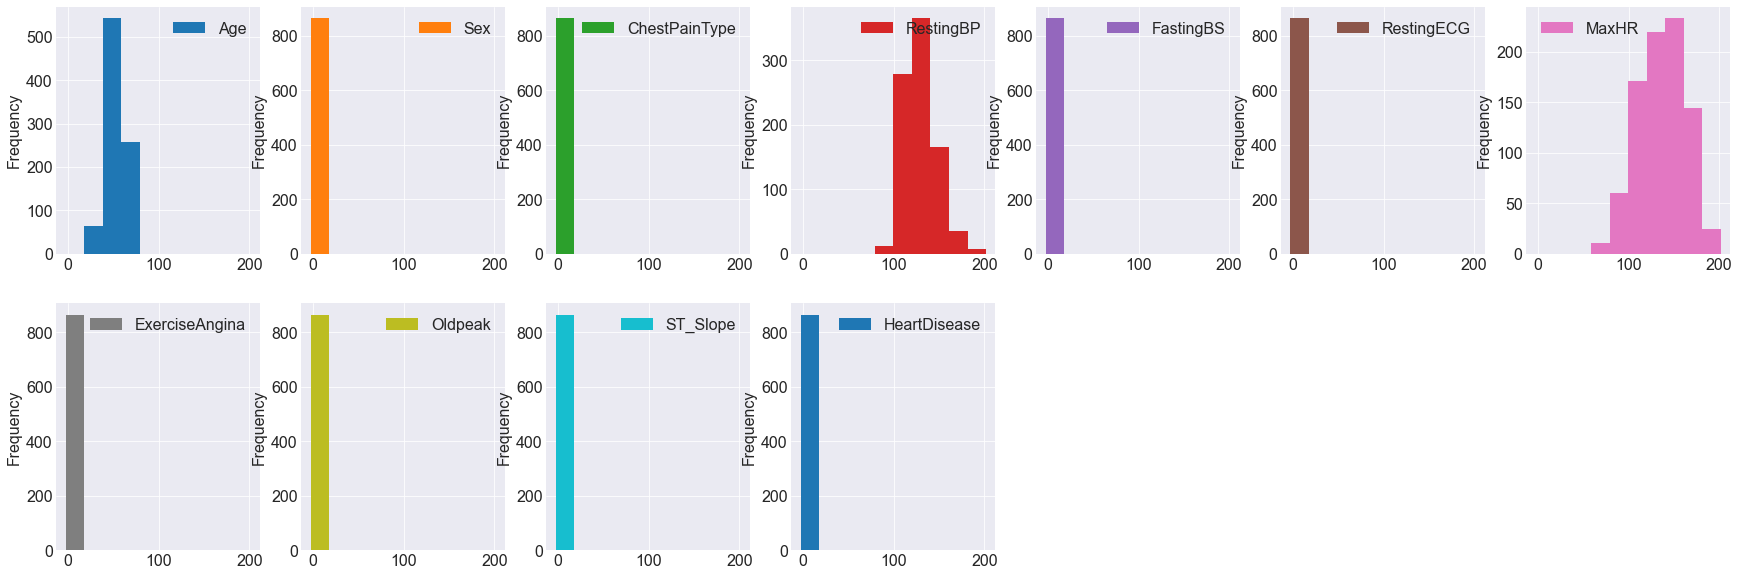

In [19]:
fig = df.plot(kind='hist', subplots=True, layout=(2,7),
sharex=False,sharey=False, figsize=(30, 10) )
# fig.savefig('boxplot.png')

In [57]:
df = df.drop(columns=['Location'])

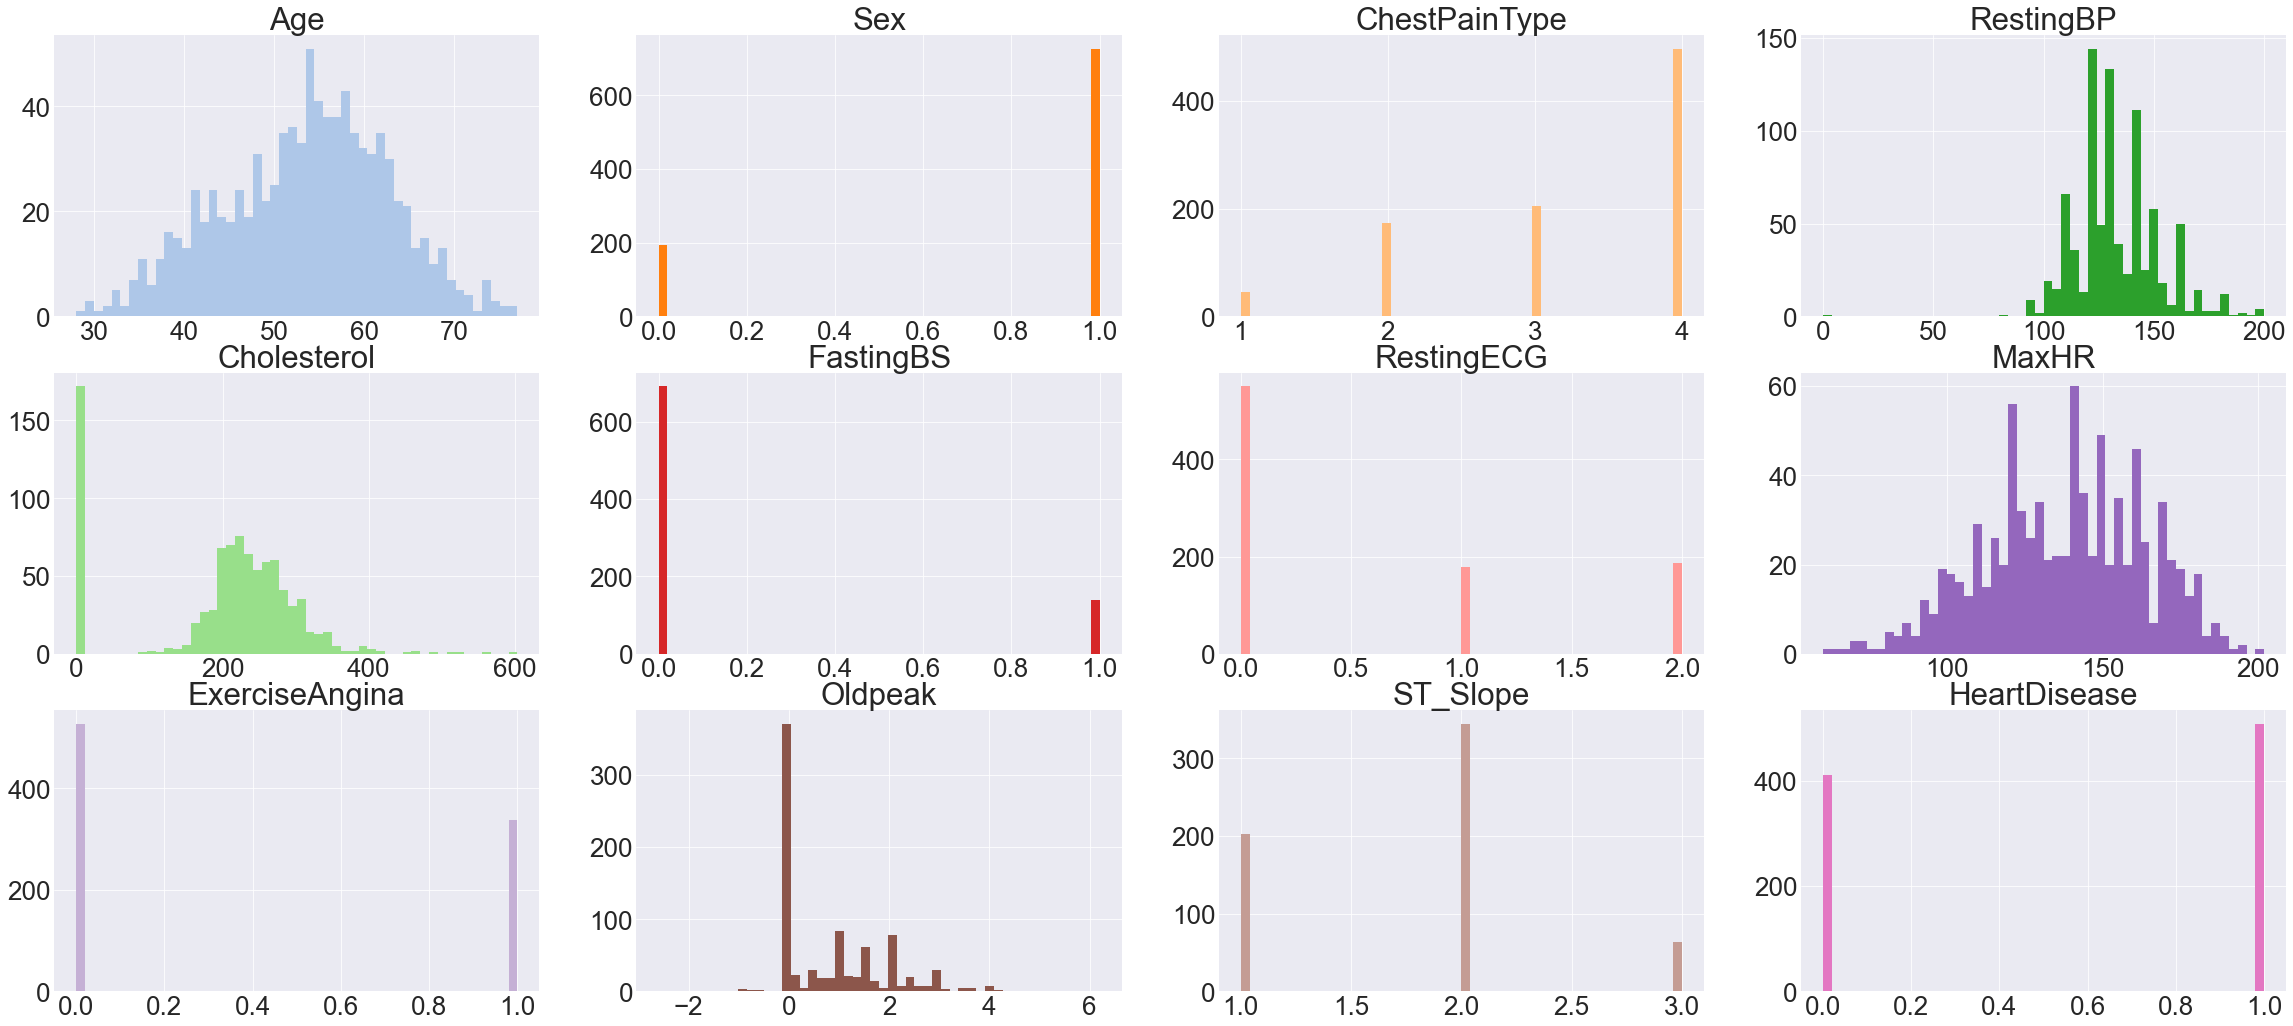

In [58]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('tab20')
plt.rcParams.update({'font.size': 26})
num=1
f2= plt.figure(figsize=(40,30))
for var in list(df.columns.array):
    ax = f2.add_subplot(5,4,num)
    a = np.asarray(df[var].dropna())
    ax.hist(a, bins=50, color=palette(num))
    ax.set_title(var)
    num+=1
f2.savefig('/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_latex/images/distribution3.png',bbox_inches='tight',  dpi=300)

In [ ]:
df[cont]

Age  RestingBP  Cholesterol  MaxHR
0    63.0      145.0        233.0  150.0
1    67.0      160.0        286.0  108.0
2    67.0      120.0        229.0  129.0
3    37.0      130.0        250.0  187.0
4    41.0      130.0        204.0  172.0
..    ...        ...          ...    ...
289  48.0      130.0        308.0  140.0
290  36.0      120.0        166.0  180.0
291  48.0      110.0        211.0  138.0
292  47.0      140.0        257.0  135.0
293  53.0      130.0        182.0  148.0

[863 rows x 4 columns]

AttributeError: 'Series' object has no attribute 'savefig'

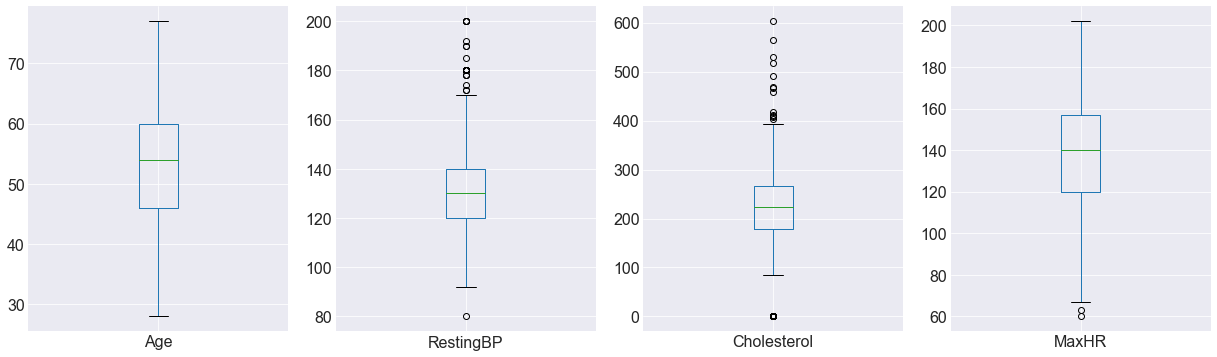

In [ ]:
fig = df[cont].plot(kind='box', subplots=True, layout=(2,7),
sharex=False,sharey=False, figsize=(30, 10) )
fig.savefig('boxplot.png')


In [75]:
# define continuous variable & plot
continous_features = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']  
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        if not drop:
            print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))
        if drop:
            df.drop(outliers, inplace = True, errors = 'ignore')
            print('Outliers from {} feature removed'.format(each_feature))

outliers(df[continous_features])

For the feature Age, No of Outliers is 0
For the feature RestingBP, No of Outliers is 27
For the feature Cholesterol, No of Outliers is 45
For the feature MaxHR, No of Outliers is 2
For the feature Oldpeak, No of Outliers is 16


1.0    472
0.0    391
Name: HeartDisease, dtype: int64


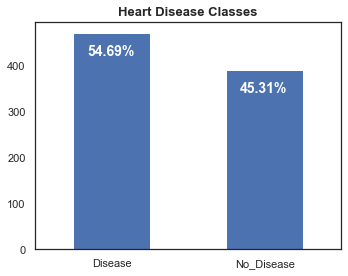

In [76]:
print(df.HeartDisease.value_counts())

# df['target'].value_counts().plot(kind='bar').set_title('Heart Disease Classes') #Simple plot

fig, ax = plt.subplots(figsize=(5,4))
name = ["Disease", "No_Disease"]
ax = df.HeartDisease.value_counts().plot(kind='bar')
ax.set_title("Heart Disease Classes", fontsize = 13, weight = 'bold')
ax.set_xticklabels (name, rotation = 0)

# To calculate the percentage
totals = []
for i in ax.patches:
    totals.append(i.get_height())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_x()+.09, i.get_height()-50, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=14,
                color='white', weight = 'bold')
    
plt.tight_layout()

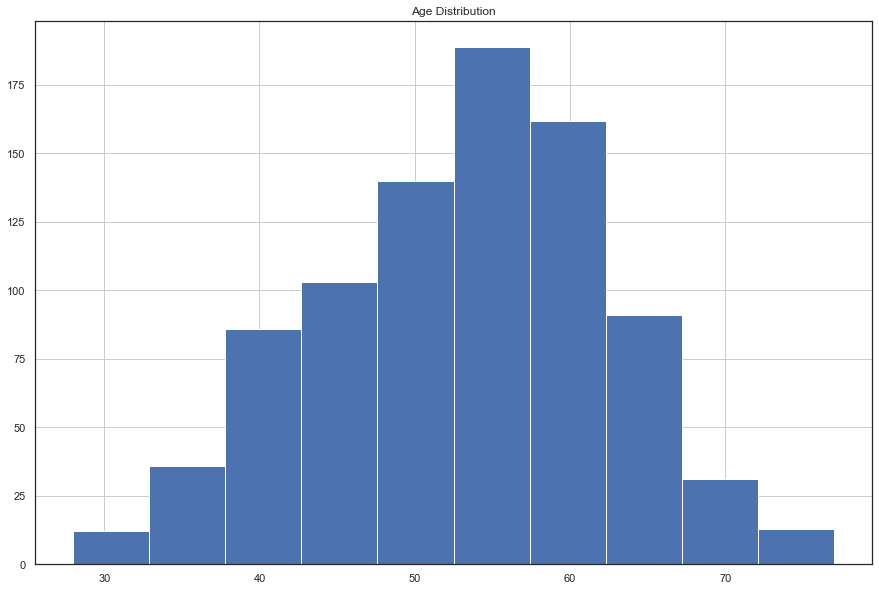

In [77]:
df.Age.hist().plot(kind='bar')
# plt.tight_layout()
plt.title('Age Distribution')
plt.show()

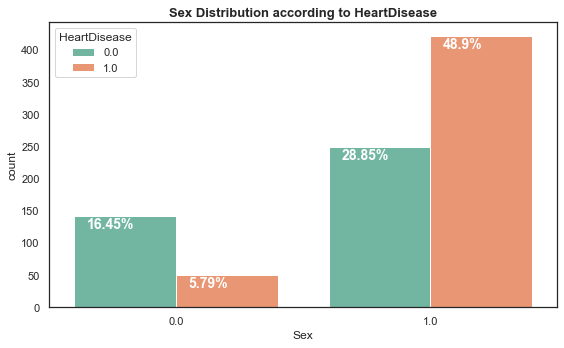

In [78]:
fig, ax = plt.subplots(figsize=(8,5))
# name = df['Sex']
ax = sns.countplot(x='Sex', hue='HeartDisease', data=df, palette='Set2')
ax.set_title("Sex Distribution according to HeartDisease", fontsize = 13, weight = 'bold')
# ax.set_xticklabels (name, rotation = 0)

totals = []
for i in ax.patches:
    totals.append(i.get_height())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_x()+.05, i.get_height()-20,
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=14,
                color='white', weight = 'bold')  
plt.tight_layout()

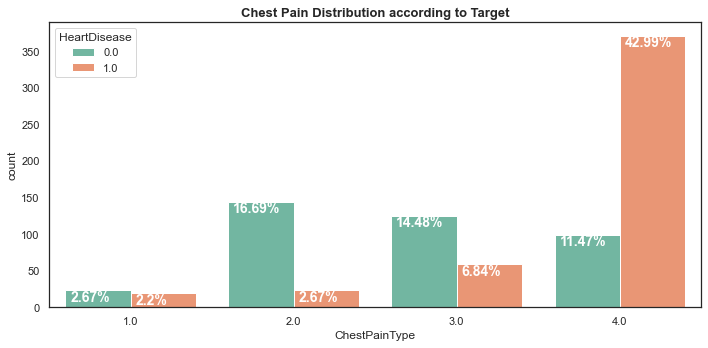

In [79]:
fig, ax = plt.subplots(figsize=(10,5))
# name = df['ChestPainType']
ax = sns.countplot(x='ChestPainType', hue='HeartDisease', data=df, palette='Set2')
ax.set_title("Chest Pain Distribution according to Target", fontsize = 13, weight = 'bold')
# ax.set_xticklabels (name, rotation = 0)

totals = []
for i in ax.patches:
    totals.append(i.get_height())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_x()+.03, i.get_height()-15,
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=14,
                color='white', weight = 'bold')  
plt.tight_layout()

<Figure size 1080x720 with 0 Axes>

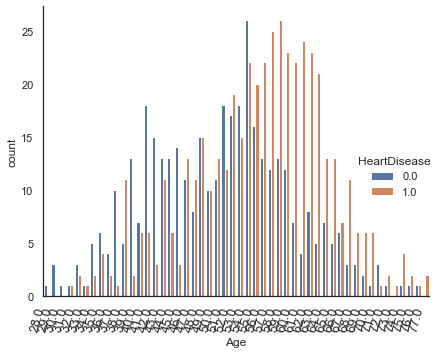

In [80]:
# fig = plt.figure(figsize=(20, 2))
# sns.set_context("paper", font_scale = 2, rc = {"font.size": 9,"axes.titlesize": 10,"axes.labelsize": 10}) 
# sns.catplot(kind = 'count', data = df, x = 'Age', hue = 'HeartDisease', order = df['Age'].sort_values().unique())
# plt.title('Variation of Age for each target class')
# plt.show()

plt.figure(figsize=(15,10)) #adjust the size of plot
ax=sns.catplot(kind = 'count', data = df, x = 'Age', hue = 'HeartDisease', order = df['Age'].sort_values().unique())
sns.set_context("paper", font_scale = 2, rc = {"font.size": 9,"axes.titlesize": 10,"axes.labelsize": 10}) 
plt.xticks(
    rotation=75, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.tight_layout()
plt.show()

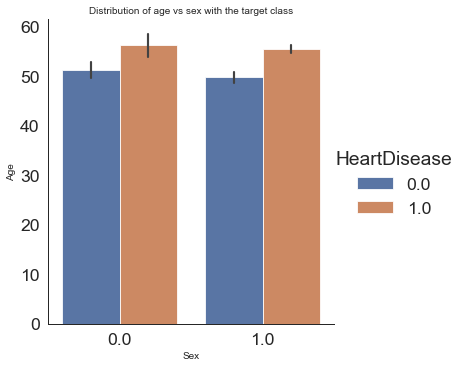

In [81]:
sns.catplot(kind = 'bar', data = df, y = 'Age', x = 'Sex', hue = 'HeartDisease')
plt.title('Distribution of age vs sex with the target class')
plt.show()

In [160]:
# define continuous variable & plot
# continous_features = ['age', 'chol', 'thalach', 'oldpeak','trestbps']  
continous_features = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak', 'HeartDisease']  
df_new = df[continous_features].reset_index()
sns.pairplot(df_new[continous_features], hue='HeartDisease')

In [161]:
sns.lmplot(x="Age", y="Cholesterol", hue="Sex", col="HeartDisease",
           markers=["o", "x"],
           palette="Set1",
           data=df)
plt.show()

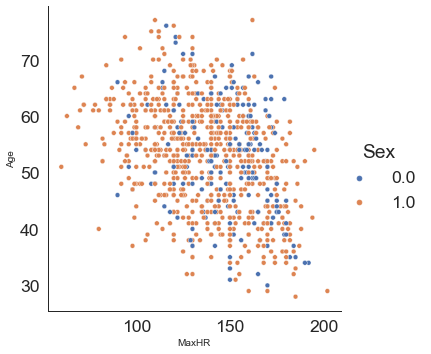

In [84]:
sns.relplot(x='MaxHR', y = 'Age', hue='Sex', data=df )

In [5]:
va_df_n = new_df(va_df)

In [18]:
va_df_n.corr()

Age       Sex  ChestPainType  RestingBP  FastingBS  \
Age             1.000000  0.060474       0.037878   0.220806   0.162168   
Sex             0.060474  1.000000       0.004333   0.023492  -0.112082   
ChestPainType   0.037878  0.004333       1.000000   0.076581  -0.143076   
RestingBP       0.220806  0.023492       0.076581   1.000000   0.238199   
FastingBS       0.162168 -0.112082      -0.143076   0.238199   1.000000   
RestingECG      0.062200  0.032531      -0.023986   0.071661   0.152971   
MaxHR          -0.174422 -0.001467      -0.162027   0.059991   0.044038   
ExerciseAngina  0.157984  0.017238       0.241342   0.188388  -0.252880   
Oldpeak         0.180768  0.109499       0.037655   0.146342  -0.128862   
ST_Slope        0.125443  0.099326       0.052245   0.089425  -0.004947   
HeartDisease    0.207250  0.082310       0.132698   0.133003   0.010680   

                RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  \
Age               0.062200 -0.174422        0.157984  0.180768  0.125443   
Sex               0.032531 -0.001467        0.017238  0.109499  0.099326   
ChestPainType    -0.023986 -0.162027        0.241342  0.037655  0.052245   
RestingBP         0.071661  0.059991        0.188388  0.146342  0.089425   
FastingBS         0.152971  0.044038       -0.252880 -0.128862 -0.004947   
RestingECG        1.000000  0.014892       -0.095428 -0.119587 -0.042564   
MaxHR             0.014892  1.000000       -0.074099  0.177305 -0.107883   
ExerciseAngina   -0.095428 -0.074099        1.000000  0.315652  0.146954   
Oldpeak          -0.119587  0.177305        0.315652  1.000000  0.293255   
ST_Slope         -0.042564 -0.107883        0.146954  0.293255  1.000000   
HeartDisease     -0.071669 -0.050814        0.297438  0.264008  0.086088   

                HeartDisease  
Age                 0.207250  
Sex                 0.082310  
ChestPainType       0.132698  
RestingBP           0.133003  
FastingBS           0.010680  
RestingECG         -0.071669  
MaxHR              -0.050814  
ExerciseAngina      0.297438  
Oldpeak             0.264008  
ST_Slope            0.086088  
HeartDisease        1.000000

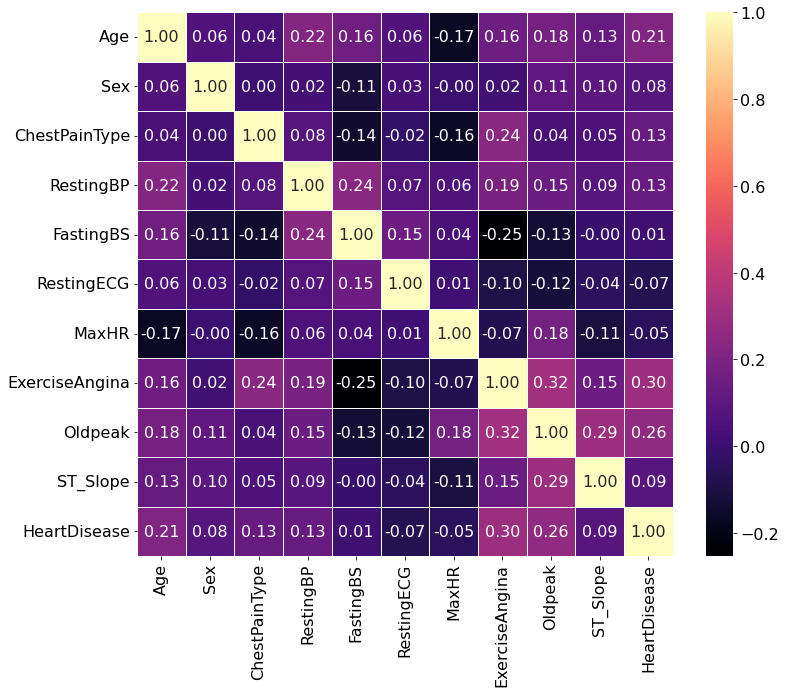

In [28]:
# sns.color_palette("flare", as_cmap=True)
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['font.size'] = 15
sns.heatmap(va_df_n.corr(), annot = True, linewidths=.5, cmap="magma",fmt='.2f')
# plt.title('Corelation Between Variables', fontsize = 30)
plt.savefig('images/corr_heatmap_VA',bbox_inches='tight',  dpi=300)
plt.savefig('/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_latex/images/corr_heatmap_VA',bbox_inches='tight',  dpi=300)
plt.show()

In [86]:
df.describe()

Age         Sex  ChestPainType   RestingBP  Cholesterol  \
count  863.000000  863.000000     863.000000  863.000000   863.000000   
mean    53.126304    0.777520       3.253766  132.278100   242.149479   
std      9.402771    0.416153       0.932418   18.479287    52.797271   
min     28.000000    0.000000       1.000000   80.000000    85.000000   
25%     46.000000    1.000000       3.000000  120.000000   218.000000   
50%     54.000000    1.000000       4.000000  130.000000   224.000000   
75%     60.000000    1.000000       4.000000  140.000000   266.500000   
max     77.000000    1.000000       4.000000  200.000000   603.000000   

        FastingBS  RestingECG       MaxHR  ExerciseAngina     Oldpeak  \
count  863.000000  863.000000  863.000000      863.000000  863.000000   
mean     0.135574    0.593279  137.524913        0.389340    0.876593   
std      0.342534    0.813346   25.929836        0.487883    1.087637   
min      0.000000    0.000000   60.000000        0.000000   -2.600000   
25%      0.000000    0.000000  120.000000        0.000000    0.000000   
50%      0.000000    0.000000  140.000000        0.000000    0.500000   
75%      0.000000    1.000000  157.000000        1.000000    1.500000   
max      1.000000    2.000000  202.000000        1.000000    6.200000   

         ST_Slope  HeartDisease  
count  863.000000    863.000000  
mean     1.837775      0.546929  
std      0.531260      0.498081  
min      1.000000      0.000000  
25%      2.000000      0.000000  
50%      2.000000      1.000000  
75%      2.000000      1.000000  
max      3.000000      1.000000

In [87]:
plt.scatter(df.ST_Slope, df.Oldpeak)
plt.show()

In [ ]:
# pp.ProfileReport(df)

def chance_of_dead_tree(N: int, a: int, b: int) -> float:

    """ N = number of samples without replacement. a = number of samples in class a, b = number of samples in class b """

    def inner(N: int, aa: int, bb: int) -> float:

        if N <= aa:

            total = 1.

            aabb = aa + bb

            for n in range(N):

                total *= (aa - n) / (aabb - n)

        else:

            total = 0
        return total

    return inner(N, a, b) + inner(N, b, a)

In [ ]:
for i in clients:
    sample = np.random.randint(1/2*len(i.y), len(i.y))
    print(sample)
    print(chance_of_dead_tree(sample, sum(i.y == 0), sum(i.y == 1)))

In [ ]:
pp.ProfileReport(switzerland_df)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


In [ ]:
pp.ProfileReport(va_df)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


In [ ]:
pp.ProfileReport(hungarian_df)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


In [163]:
binary_feature_names = ['Sex', 'FastingBS', 'ExerciseAngina']
categorical_feature_names = ['ChestPainType', 'RestingECG', 'ST_Slope']

In [168]:
possible_values = dict()
for i in categorical_feature_names:
    possible_values[i] = df[i].unique()


In [171]:
possible_values = dict()
for i in categorical_feature_names:
    possible_values[i] = df[i].unique()

for feature in categorical_feature_names:
    list_of_possible_values = [feature + '_' + str(value) for value in possible_values[feature]]
    dummies = pd.get_dummies(df[feature], prefix = feature).T.reindex(list_of_possible_values).T.fillna(0)
    df = pd.concat([df, dummies], axis=1)

df = df.drop(categorical_feature_names, axis = 1)

In [174]:
df = df.drop(categorical_feature_names, axis = 1)

In [175]:
df

Age  Sex  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
0    63.0  1.0      145.0        233.0        1.0  150.0             0.0   
1    67.0  1.0      160.0        286.0        0.0  108.0             1.0   
2    67.0  1.0      120.0        229.0        0.0  129.0             1.0   
3    37.0  1.0      130.0        250.0        0.0  187.0             0.0   
4    41.0  0.0      130.0        204.0        0.0  172.0             0.0   
..    ...  ...        ...          ...        ...    ...             ...   
289  48.0  0.0      130.0        308.0        0.0  140.0             0.0   
290  36.0  1.0      120.0        166.0        0.0  180.0             0.0   
291  48.0  1.0      110.0        211.0        0.0  138.0             0.0   
292  47.0  0.0      140.0        257.0        0.0  135.0             0.0   
293  53.0  1.0      130.0        182.0        0.0  148.0             0.0   

     Oldpeak  HeartDisease   Location  ChestPainType_1.0  ChestPainType_4.0  \
0        2.3           0.0  Cleveland                  1                  0   
1        1.5           1.0  Cleveland                  0                  1   
2        2.6           1.0  Cleveland                  0                  1   
3        3.5           0.0  Cleveland                  0                  0   
4        1.4           0.0  Cleveland                  0                  0   
..       ...           ...        ...                ...                ...   
289      2.0           0.0  Hungarian                  0                  0   
290      0.0           0.0  Hungarian                  0                  0   
291      0.0           0.0  Hungarian                  0                  0   
292      1.0           0.0  Hungarian                  0                  0   
293      0.0           0.0  Hungarian                  0                  1   

     ChestPainType_3.0  ChestPainType_2.0  RestingECG_2.0  RestingECG_0.0  \
0                    0                  0               1               0   
1                    0                  0               1               0   
2                    0                  0               1               0   
3                    1                  0               0               1   
4                    0                  1               1               0   
..                 ...                ...             ...             ...   
289                  0                  1               0               0   
290                  0                  1               0               1   
291                  1                  0               0               1   
292                  0                  1               0               1   
293                  0                  0               0               1   

     RestingECG_1.0  ST_Slope_3.0  ST_Slope_2.0  ST_Slope_1.0  
0                 0             1             0             0  
1                 0             0             1             0  
2                 0             0             1             0  
3                 0             1             0             0  
4                 0             0             0             1  
..              ...           ...           ...           ...  
289               1             0             0             1  
290               0             0             1             0  
291               0             0             1             0  
292               0             0             0             1  
293               0             0             1             0  

[863 rows x 20 columns]